# Микродиахроническое исследование русских приставок методами дистрибутивной семантики
## Автор: Елизавета Клыкова, БКЛ181
### Выравнивание моделей, анализ изменений и кластеризация
1. Взять код Orthogonal Procrustes alignment у Hamilton et al. (2016)
2. Выровнять модели: советский с досоветским, постсоветский с советским
3. Повторить для fasttext и для word2vec на леммах + частях речи
4. Рассчитать попарное расстояние Манхэттэна для релевантных периодов
5. Отранжировать глаголы внутри приставки и приставки относительно друг друга
6. Кластеризовать глаголы внутри каждой приставки в разные периоды и посмотреть на изменения

#### Импорт модулей

In [1]:
# %load_ext pycodestyle_magic
# %pycodestyle_on

In [2]:
import gensim
import pickle
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from statistics import mean
import scipy.cluster.hierarchy as hcluster
from sklearn.cluster import AffinityPropagation
import matplotlib.pyplot as plt
from scipy.spatial.distance import cityblock
from gensim.models.fasttext import load_facebook_model

import warnings
warnings.filterwarnings('ignore')

#### Загрузка моделей

In [3]:
def load_word2vec_model(file_with_model):
    model = gensim.models.KeyedVectors.load_word2vec_format(file_with_model,
                                                            binary=True)
    print('Размер словаря:', len(model.wv.vocab))
    return model

#### Word2vec (леммы)

In [4]:
wv_presov = load_word2vec_model('word2vec/word2vec_presov_lemmas.bin')

Размер словаря: 127656


In [5]:
wv_sov = load_word2vec_model('word2vec/word2vec_sov_lemmas.bin')

Размер словаря: 151890


In [6]:
wv_postsov = load_word2vec_model('word2vec/word2vec_postsov_lemmas.bin')

Размер словаря: 149617


#### Word2vec (леммы + части речи)

In [7]:
wv_pos_presov = load_word2vec_model('word2vec/word2vec_presov_lemmas_pos.bin')

Размер словаря: 123804


In [8]:
wv_pos_sov = load_word2vec_model('word2vec/word2vec_sov_lemmas_pos.bin')

Размер словаря: 147146


In [9]:
wv_pos_postsov = load_word2vec_model('word2vec/word2vec_postsov_lemmas_pos.bin')

Размер словаря: 144650


#### FastText

In [10]:
ft_presov = load_facebook_model('fasttext/fasttext_presov_lemmas.bin')
ft_presov.init_sims(replace=True)
print('Размер словаря:', len(ft_presov.wv.vocab))

Размер словаря: 127657


In [11]:
ft_sov = load_facebook_model('fasttext/fasttext_sov_lemmas.bin')
ft_sov.init_sims(replace=True)
print('Размер словаря:', len(ft_sov.wv.vocab))

Размер словаря: 151891


In [12]:
ft_postsov = load_facebook_model('fasttext/fasttext_postsov_lemmas.bin')
ft_postsov.init_sims(replace=True)
print('Размер словаря:', len(ft_postsov.wv.vocab))

Размер словаря: 149618


#### Выравнивание: Orthogonal Procrustes alignment, (Hamilton et al. 2016)
Код взят [отсюда](https://gist.github.com/zhicongchen/9e23d5c3f1e5b1293b16133485cd17d8).

In [13]:
def intersection_align_gensim(m1, m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words:
        common_vocab &= set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1, m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count, reverse=True)

    # Then for each model...
    for m in [m1, m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = m.wv.syn0norm
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.wv.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index, word in enumerate(common_vocab):
            old_vocab_obj = old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1, m2)

In [14]:
def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """
    Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
        (With help from William. Thank you!)

    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.

    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """

    # patch by Richard So [https://twitter.com/richardjeanso] (thanks!) to update this code for new version of gensim
    base_embed.init_sims()
    other_embed.init_sims()

    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = in_base_embed.wv.syn0norm
    other_vecs = in_other_embed.wv.syn0norm

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs)
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v)
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (other_embed.wv.syn0norm).dot(ortho)

    return other_embed

Выравниваем word2vec на леммах:

In [15]:
wv_sov_to_presov = smart_procrustes_align_gensim(wv_presov, wv_sov)

In [16]:
wv_postsov_to_sov = smart_procrustes_align_gensim(wv_sov, wv_postsov)

Выравниваем word2vec с частями речи:

In [17]:
wv_pos_sov_to_presov = smart_procrustes_align_gensim(wv_pos_presov, wv_pos_sov)

In [18]:
wv_pos_postsov_to_sov = smart_procrustes_align_gensim(wv_pos_sov, wv_pos_postsov)

Выравниваем fastText-модели:

In [19]:
ft_sov_to_presov = smart_procrustes_align_gensim(ft_presov, ft_sov)

In [20]:
ft_postsov_to_sov = smart_procrustes_align_gensim(ft_sov, ft_postsov)

#### Получение векторов глаголов

In [21]:
pref_df = pd.read_csv('prefixes_and_lemmas_freq.tsv', sep='\t')
pref_df.head()

,prefix,lemma,abs_freq,abs_freq0,abs_freq1,abs_freq2,freq,freq0,freq1,freq2
0,бе[зс],бездействовать,541,155,255,131,2.194,2.147,2.741,1.609
1,бе[зс],бездельничать,308,41,169,98,1.249,0.568,1.817,1.204
2,бе[зс],безмолвствовать,726,361,191,174,2.944,5.000,2.053,2.138
3,бе[зс],безобразить,149,99,43,7,0.604,1.371,0.462,0.086
4,бе[зс],безобразничать,306,110,136,60,1.241,1.524,1.462,0.737


In [22]:
# list of dicts
pref_dict = pref_df.to_dict(orient='records')

Нам нужны:
- вектор досоветского периода
- вектор советского периода, выровненный с досоветским
- вектор постсоветского периода, выровненный с советским (и досоветским по определению)
- было проверено, что при выравнивании постсоветского с досоветским получаются те же векторы
- все то же самое для моделей с частями речи
- все то же самое для fastText-моделей

In [23]:
for verb in pref_dict:
    # word2vec на леммах
    lemma = verb['lemma']
    verb['wv_presov'] = wv_presov[lemma] if lemma in wv_presov else None
    verb['wv_sov'] = wv_sov_to_presov[lemma] if lemma in wv_sov_to_presov else None
    verb['wv_postsov'] = wv_postsov_to_sov[lemma] if lemma in wv_postsov_to_sov else None
    # word2vec с частями речи
    lemma_pos = verb['lemma'] + '_' + 'V'
    verb['wvpos_presov'] = wv_pos_presov[lemma_pos] if lemma_pos in wv_pos_presov else None
    verb['wvpos_sov'] = wv_pos_sov_to_presov[lemma_pos] if lemma_pos in wv_pos_sov_to_presov else None
    verb['wvpos_postsov'] = wv_pos_postsov_to_sov[lemma_pos] if lemma_pos in wv_pos_postsov_to_sov else None
    # fasttext
    verb['ft_presov'] = ft_presov[lemma] if lemma in ft_presov else None
    verb['ft_sov'] = ft_sov_to_presov[lemma] if lemma in ft_sov_to_presov else None
    verb['ft_postsov'] = ft_postsov_to_sov[lemma] if lemma in ft_postsov_to_sov else None

In [24]:
vector_df = pd.DataFrame(pref_dict)
vector_df.head(3)

,prefix,lemma,abs_freq,abs_freq0,abs_freq1,abs_freq2,freq,freq0,freq1,freq2,wv_presov,wv_sov,wv_postsov,wvpos_presov,wvpos_sov,wvpos_postsov,ft_presov,ft_sov,ft_postsov
0,бе[зс],бездействовать,541,155,255,131,2.194,2.147,2.741,1.609,"[-0.023052273, -0.12562126, -0.0661711, -0.056...","[0.045035847, -0.089103796, -0.104690984, 0.03...","[0.10868745, -0.006713072, -0.121952675, 0.040...","[-0.03860679, 0.017324327, 0.04515939, 0.00860...","[0.013748187, 0.0057130447, 0.11317766, 0.0329...","[-0.075591795, -0.041445807, 0.08768769, -0.04...","[-0.03743155, 0.08501605, 0.06470327, 0.121702...","[-0.056611735, 0.089228176, 0.050963335, 0.117...","[-0.07614583, 0.111062504, 0.10515018, 0.12608..."
1,бе[зс],бездельничать,308,41,169,98,1.249,0.568,1.817,1.204,"[0.086817734, -0.027619349, 0.010952894, -0.07...","[0.07287336, -0.07627704, 0.025137031, 0.08807...","[0.028157884, -0.0708785, -0.0076874625, 0.026...","[0.04126555, -0.021287525, 0.08565935, -0.0361...","[0.07325783, -0.0040860167, 0.026817102, -0.02...","[-0.0110313045, 0.07867826, 0.024997363, -0.06...","[-0.053011004, 0.047406126, 0.13473499, 0.0451...","[-0.026981538, 0.06025122, 0.10029247, 0.02105...","[-0.06522496, 0.078543365, 0.09723295, 0.06298..."
2,бе[зс],безмолвствовать,726,361,191,174,2.944,5.000,2.053,2.138,"[0.032911796, -0.08076292, -0.08197429, -0.090...","[0.13080676, 0.014954596, -0.07196053, 0.01733...","[0.06310802, 0.007184277, -0.022681594, 0.0052...","[-0.075714454, 0.1076868, 0.07268564, -0.02730...","[-0.023441153, -0.019269854, 0.12296256, 0.096...","[0.0146042025, 0.010473826, 0.1419688, 0.00868...","[-0.056494866, 0.10670928, 0.15303405, 0.06594...","[-0.053572807, 0.05914339, 0.14568467, 0.09370...","[-0.05812422, 0.052551158, 0.15714656, 0.07250..."


In [25]:
vector_df.shape[0] - vector_df.dropna().shape[0]

11

In [26]:
vector_df.dropna(inplace=True)
pref_dict = vector_df.to_dict(orient='records')

In [ ]:
vector_df.drop(columns=['wv_presov', 'wv_sov', 'wv_postsov',
                        'wvpos_presov', 'wvpos_sov', 'wvpos_postsov',
                        'ft_presov', 'ft_sov', 'ft_postsov'],
               inplace=True)

In [ ]:
vector_df.to_csv('prefixes_and_lemmas_dropna.tsv', sep='\t', index=False)

#### Выявление изменений с помощью расстояния Манхеттена
Расстояние Манхэттэна: Σ|Ai – Bi|. Для каждой леммы считаем расстояние между советским и досоветским, постсоветским и советским, постсоветским и досоветским (+ то же самое для модели с частями речи и для fastText).

In [27]:
for verb in tqdm(pref_dict):
    # word2vec на леммах
    verb['wv_pre_to_sov'] = round(cityblock(verb['wv_presov'], verb['wv_sov']), 3)
    verb['wv_sov_to_post'] = round(cityblock(verb['wv_sov'], verb['wv_postsov']), 3)
    verb['wv_pre_to_post'] = round(cityblock(verb['wv_presov'], verb['wv_postsov']), 3)
    # word2vec с частями речи
    verb['wvpos_pre_to_sov'] = round(cityblock(verb['wvpos_presov'], verb['wvpos_sov']), 3)
    verb['wvpos_sov_to_post'] = round(cityblock(verb['wvpos_sov'], verb['wvpos_postsov']), 3)
    verb['wvpos_pre_to_post'] = round(cityblock(verb['wvpos_presov'], verb['wvpos_postsov']), 3)
    # fasttext
    verb['ft_pre_to_sov'] = round(cityblock(verb['ft_presov'], verb['ft_sov']), 3)
    verb['ft_sov_to_post'] = round(cityblock(verb['ft_sov'], verb['ft_postsov']), 3)
    verb['ft_pre_to_post'] = round(cityblock(verb['ft_presov'], verb['ft_postsov']), 3)

  0%|          | 0/8434 [00:00<?, ?it/s]

Внутри каждой приставки и каждого периода отранжируем приставки по степени изменения.

In [28]:
prefixes = sorted(list(set([verb['prefix'] for verb in pref_dict])))

In [29]:
w2v_lemma_dict = {}
w2v_pos_dict = {}
ft_lemma_dict = {}

for prefix in prefixes:
    w2v_lemma_dict[prefix] = []
    w2v_pos_dict[prefix] = []
    ft_lemma_dict[prefix] = []

for verb in pref_dict:
    w2v_lemma_dict[verb['prefix']].append(verb)
    w2v_pos_dict[verb['prefix']].append(verb)
    ft_lemma_dict[verb['prefix']].append(verb)

#### Считаем для базовых моделей

In [30]:
for prefix in w2v_lemma_dict:
    verbs = w2v_lemma_dict[prefix]
    pre_to_sov = [(verb['lemma'], verb['wv_pre_to_sov'])
                  for verb in sorted(verbs,
                                     key=lambda x: x['wv_pre_to_sov'],
                                     reverse=True)]
    sov_to_post = [(verb['lemma'], verb['wv_sov_to_post'])
                   for verb in sorted(verbs,
                                      key=lambda x: x['wv_sov_to_post'],
                                      reverse=True)]
    pre_to_post = [(verb['lemma'], verb['wv_pre_to_post'])
                   for verb in sorted(verbs,
                                      key=lambda x: x['wv_pre_to_post'],
                                      reverse=True)]
    w2v_lemma_dict[prefix] = {'pre_to_sov_mean': round(mean([v[1] for v in pre_to_sov]), 3),
                              'sov_to_post_mean': round(mean([v[1] for v in sov_to_post]), 3),
                              'pre_to_post_mean': round(mean([v[1] for v in pre_to_post]), 3),
                              'pre_to_sov_ranged': pre_to_sov,
                              'sov_to_post_ranged': sov_to_post,
                              'pre_to_post_ranged': pre_to_post}

In [31]:
w2v_lemma_dict['полу']['sov_to_post_mean']

14.401

#### Ранжирование приставок по средней степени изменения в период

In [32]:
prefs_pre_to_sov_ranged = [pref
                           for pref in sorted(w2v_lemma_dict,
                                              key=lambda x: w2v_lemma_dict[x]['pre_to_sov_mean'],
                                              reverse=True)]

In [33]:
prefs_sov_to_post_ranged = [pref
                            for pref in sorted(w2v_lemma_dict,
                                               key=lambda x: w2v_lemma_dict[x]['sov_to_post_mean'],
                                               reverse=True)]

In [34]:
prefs_pre_to_post_ranged = [pref
                            for pref in sorted(w2v_lemma_dict,
                                               key=lambda x: w2v_lemma_dict[x]['pre_to_post_mean'],
                                               reverse=True)]

#### Повторяем все, что выше, для моделей с частями речи

In [35]:
for prefix in w2v_pos_dict:
    verbs = w2v_pos_dict[prefix]
    pre_to_sov = [(verb['lemma'], verb['wvpos_pre_to_sov'])
                  for verb in sorted(verbs,
                                     key=lambda x: x['wvpos_pre_to_sov'],
                                     reverse=True)]
    sov_to_post = [(verb['lemma'], verb['wvpos_sov_to_post'])
                   for verb in sorted(verbs,
                                      key=lambda x: x['wvpos_sov_to_post'],
                                      reverse=True)]
    pre_to_post = [(verb['lemma'], verb['wvpos_pre_to_post'])
                   for verb in sorted(verbs,
                                      key=lambda x: x['wvpos_pre_to_post'],
                                      reverse=True)]
    w2v_pos_dict[prefix] = {'pre_to_sov_mean': round(mean([v[1] for v in pre_to_sov]), 3),
                            'sov_to_post_mean': round(mean([v[1] for v in sov_to_post]), 3),
                            'pre_to_post_mean': round(mean([v[1] for v in pre_to_post]), 3),
                            'pre_to_sov_ranged': pre_to_sov,
                            'sov_to_post_ranged': sov_to_post,
                            'pre_to_post_ranged': pre_to_post}

In [36]:
prefs_pre_to_sov_pos_ranged = [pref
                               for pref in sorted(w2v_pos_dict,
                                                  key=lambda x: w2v_pos_dict[x]['pre_to_sov_mean'],
                                                  reverse=True)]

In [37]:
prefs_sov_to_post_pos_ranged = [pref
                                for pref in sorted(w2v_pos_dict,
                                                   key=lambda x: w2v_pos_dict[x]['sov_to_post_mean'],
                                                   reverse=True)]

In [38]:
prefs_pre_to_post_pos_ranged = [pref
                                for pref in sorted(w2v_pos_dict,
                                                   key=lambda x: w2v_pos_dict[x]['pre_to_post_mean'],
                                                   reverse=True)]

#### Повторяем для fastText

In [39]:
for prefix in ft_lemma_dict:
    verbs = ft_lemma_dict[prefix]
    pre_to_sov = [(verb['lemma'], verb['ft_pre_to_sov'])
                  for verb in sorted(verbs,
                                     key=lambda x: x['ft_pre_to_sov'],
                                     reverse=True)]
    sov_to_post = [(verb['lemma'], verb['ft_sov_to_post'])
                   for verb in sorted(verbs,
                                      key=lambda x: x['ft_sov_to_post'],
                                      reverse=True)]
    pre_to_post = [(verb['lemma'], verb['ft_pre_to_post'])
                   for verb in sorted(verbs,
                                      key=lambda x: x['ft_pre_to_post'],
                                      reverse=True)]
    ft_lemma_dict[prefix] = {'pre_to_sov_mean': round(mean([v[1] for v in pre_to_sov]), 3),
                             'sov_to_post_mean': round(mean([v[1] for v in sov_to_post]), 3),
                             'pre_to_post_mean': round(mean([v[1] for v in pre_to_post]), 3),
                             'pre_to_sov_ranged': pre_to_sov,
                             'sov_to_post_ranged': sov_to_post,
                             'pre_to_post_ranged': pre_to_post}

In [40]:
prefs_pre_to_sov_ft_ranged = [pref
                              for pref in sorted(ft_lemma_dict,
                                                 key=lambda x: ft_lemma_dict[x]['pre_to_sov_mean'],
                                                 reverse=True)]

In [41]:
prefs_sov_to_post_ft_ranged = [pref
                               for pref in sorted(ft_lemma_dict,
                                                  key=lambda x: ft_lemma_dict[x]['sov_to_post_mean'],
                                                  reverse=True)]

In [42]:
prefs_pre_to_post_ft_ranged = [pref
                               for pref in sorted(ft_lemma_dict,
                                                  key=lambda x: ft_lemma_dict[x]['pre_to_post_mean'],
                                                  reverse=True)]

#### FastText для отдельных приставок

In [43]:
ft_prefs = [['без-', 'бес-', 'безо-'], ['вз-', 'вс-', 'взо-'], ['в-', 'во-'],
            ['воз-', 'вос-', 'возо-'], ['вы-'], ['до-'], ['за-'], ['из-', 'ис-', 'изо-'],
            ['на-'], ['над-', 'надо-'], ['недо-'], ['низ-', 'нис-', 'низо-'],
            ['о-', 'об-', 'обо-'], ['обез-', 'обес-'], ['от-', 'ото-'], ['пере-'],
            ['по-'], ['под-', 'подо-'], ['полу-'], ['пре-'], ['пред-', 'предо-'],
            ['при-'], ['про-'], ['раз-', 'рас-', 'разо-'], ['с-', 'со-'], ['у-']]

In [44]:
ft_pref_dict = {}

for prefix in ft_prefs:
    ft_pref_presov = []
    ft_pref_sov = []
    ft_pref_postsov = []
    for rep in prefix:
        ft_pref_presov.append(ft_presov[rep.strip('-')])
        ft_pref_sov.append(ft_sov_to_presov[rep.strip('-')])
        ft_pref_postsov.append(ft_postsov_to_sov[rep.strip('-')])

    ft_pref_dict[prefix[0]] = {'presov': np.average(np.array(ft_pref_presov), axis=0),
                               'sov': np.average(np.array(ft_pref_sov), axis=0),
                               'postsov': np.average(np.array(ft_pref_postsov), axis=0)}

In [45]:
for pref in ft_pref_dict:
    ft_pref_dict[pref]['pre_to_sov'] = round(cityblock(ft_pref_dict[pref]['presov'],
                                                       ft_pref_dict[pref]['sov']), 3)
    ft_pref_dict[pref]['sov_to_post'] = round(cityblock(ft_pref_dict[pref]['sov'],
                                                       ft_pref_dict[pref]['postsov']), 3)
    ft_pref_dict[pref]['pre_to_post'] = round(cityblock(ft_pref_dict[pref]['presov'],
                                                       ft_pref_dict[pref]['postsov']), 3)

In [46]:
found_pref_dict = {}
for pref in ft_pref_dict:
    if ft_pref_dict[pref]['pre_to_sov'] > -100 and ft_pref_dict[pref]['sov_to_post'] > -100 and ft_pref_dict[pref]['pre_to_post'] > -100:
        found_pref_dict[pref] = ft_pref_dict[pref]

In [47]:
len(found_pref_dict)

22

In [48]:
prefs_pre_to_sov_ft2 = [pref
                        for pref in sorted(found_pref_dict,
                                           key=lambda x: found_pref_dict[x]['pre_to_sov'],
                                           reverse=True)]

In [49]:
prefs_sov_to_post_ft2 = [pref
                         for pref in sorted(found_pref_dict,
                                            key=lambda x: found_pref_dict[x]['sov_to_post'],
                                            reverse=True)]

In [50]:
prefs_pre_to_post_ft2 = [pref
                         for pref in sorted(found_pref_dict,
                                            key=lambda x: found_pref_dict[x]['pre_to_post'],
                                            reverse=True)]

#### Повторяем для ELMo

In [51]:
with open('verbs_to_search.pickle', 'rb') as f:
    verbs_to_search = pickle.load(f)

In [52]:
with open('prefs_verbs_10.pickle', 'rb') as f:
    prefs_verbs_10 = pickle.load(f)

In [53]:
with open('presov_samples.pickle', 'rb') as f:
    presov_samples = pickle.load(f)

In [54]:
with open('sov_samples.pickle', 'rb') as f:
    sov_samples = pickle.load(f)

In [55]:
with open('postsov_samples.pickle', 'rb') as f:
    postsov_samples = pickle.load(f)

In [56]:
verb_embeddings = {}
for verb in verbs_to_search:
    mean_presov = np.average([emb[-1] for emb in presov_samples[verb]], axis=0)
    mean_sov = np.average([emb[-1] for emb in sov_samples[verb]], axis=0)
    mean_postsov = np.average([emb[-1] for emb in postsov_samples[verb]], axis=0)
    verb_embeddings[verb] = {'presov': mean_presov,
                             'sov': mean_sov,
                             'postsov': mean_postsov,
                             'pre_to_sov': cityblock(mean_presov, mean_sov),
                             'sov_to_post': cityblock(mean_sov, mean_postsov),
                             'pre_to_post': cityblock(mean_presov, mean_postsov)}

In [57]:
pref_embeddings = {}
for pref in prefs_verbs_10:
    pref_embeddings[pref] = {}
    for verb in prefs_verbs_10[pref]:
        pref_embeddings[pref][verb] = verb_embeddings[verb]

In [58]:
pref_change = {}
for pref in pref_embeddings:
    presov_change = mean(pref_embeddings[pref][verb]['pre_to_sov']
                         for verb in pref_embeddings[pref])
    sov_change = mean(pref_embeddings[pref][verb]['sov_to_post']
                      for verb in pref_embeddings[pref])
    postsov_change = mean(pref_embeddings[pref][verb]['pre_to_post']
                          for verb in pref_embeddings[pref])
    pref_change[pref] = {'pre_to_sov': presov_change,
                         'sov_to_post': sov_change,
                         'pre_to_post': postsov_change}

In [59]:
elmo_pre_to_sov_ranged = [pref for pref in sorted(pref_change,
                                             key=lambda x: pref_change[pref]['pre_to_sov'],
                                             reverse=True)]

In [60]:
elmo_sov_to_post_ranged = [pref for pref in sorted(pref_change,
                                              key=lambda x: pref_change[pref]['sov_to_post'],
                                              reverse=True)]

In [61]:
elmo_pre_to_post_ranged = [pref for pref in sorted(pref_change,
                                              key=lambda x: pref_change[pref]['pre_to_post'],
                                              reverse=True)]

#### Собираем в датафрейм для наглядности

In [62]:
# приводим к стандартному виду
convt = {'бе[зс]': 'без-',
         'в[зс]': 'вз-',
         'во?': 'в-',
         'во[зс]': 'воз-',
         'вы': 'вы-',
         'до': 'до-',
         'за': 'за-',
         'и[зс]': 'из-',
         'на': 'на-',
         'над': 'над-',
         'недо': 'недо-',
         'ни[зс]': 'низ-',
         'о': 'о-',
         'обе[зс]': 'обез-',
         'от': 'от-',
         'пере': 'пере-',
         'по': 'по-',
         'под': 'под-',
         'полу': 'полу-',
         'пре': 'пре-',
         'пред': 'пред-',
         'при': 'при-',
         'про': 'про-',
         'ра[зс]': 'раз-',
         'с': 'с-',
         'у': 'у-'}

In [63]:
dt = {'w2vlem_pre_to_sov': prefs_pre_to_sov_ranged,
      'w2vlem_sov_to_post': prefs_sov_to_post_ranged,
      'w2vlem_pre_to_post': prefs_pre_to_post_ranged,
      'w2vpos_pre_to_sov': prefs_pre_to_sov_pos_ranged,
      'w2vpos_sov_to_post': prefs_sov_to_post_pos_ranged,
      'w2vpos_pre_to_post': prefs_pre_to_post_pos_ranged,
      'ftlem_pre_to_sov': prefs_pre_to_sov_ft_ranged,
      'ftvlem_sov_to_post': prefs_sov_to_post_ft_ranged,
      'ftvlem_pre_to_post': prefs_pre_to_post_ft_ranged,
      'elmo_pre_to_sov': elmo_pre_to_sov_ranged,
      'elmo_sov_to_post': elmo_sov_to_post_ranged,
      'elmo_pre_to_post': elmo_pre_to_post_ranged,
      }

for lst in list(dt.values()):
    for i, val in enumerate(lst):
        lst[i] = convt[val]

In [64]:
for i, pref in enumerate(prefs_pre_to_sov_ft_ranged):
    if pref not in prefs_pre_to_sov_ft2:
        print(i, pref)

0 низ-
7 пре-
13 полу-
21 раз-


In [65]:
print(prefs_pre_to_sov_ft2)

['про-', 'по-', 'за-', 'недо-', 'с-', 'до-', 'при-', 'вы-', 'от-', 'пере-', 'на-', 'над-', 'под-', 'в-', 'у-', 'пред-', 'обез-', 'из-', 'о-', 'вз-', 'без-', 'воз-']


In [66]:
prefs_pre_to_sov_ft2 = ['--', 'про-', 'по-', 'за-', 'недо-', 'с-', 'до-', '--', 'при-', 'вы-', 'от-', 'пере-', 'на-', '--', 'над-', 'под-', 'в-', 'у-', 'пред-', 'обез-', 'из-', '--', 'о-', 'вз-', 'без-', 'воз-']

In [67]:
for i, pref in enumerate(prefs_sov_to_post_ft_ranged):
    if pref not in prefs_sov_to_post_ft2:
        print(i, pref)

0 низ-
7 полу-
13 пре-
24 раз-


In [68]:
print(prefs_sov_to_post_ft2)

['с-', 'от-', 'по-', 'недо-', 'про-', 'при-', 'о-', 'до-', 'пред-', 'за-', 'на-', 'пере-', 'вз-', 'под-', 'в-', 'обез-', 'вы-', 'воз-', 'из-', 'без-', 'у-', 'над-']


In [69]:
prefs_sov_to_post_ft2 = ['--', 'с-', 'от-', 'по-', 'недо-', 'про-', 'при-', '--', 'о-', 'до-', 'пред-', 'за-', 'на-', '--', 'пере-', 'вз-', 'под-', 'в-', 'обез-', 'вы-', 'воз-', 'из-', 'без-', 'у-', '--', 'над-']

In [70]:
for i, pref in enumerate(prefs_pre_to_post_ft_ranged):
    if pref not in prefs_pre_to_post_ft2:
        print(i, pref)

1 пре-
3 низ-
9 полу-
24 раз-


In [71]:
print(prefs_pre_to_post_ft2)

['с-', 'про-', 'за-', 'до-', 'пред-', 'по-', 'от-', 'у-', 'над-', 'при-', 'вз-', 'на-', 'под-', 'о-', 'пере-', 'недо-', 'вы-', 'в-', 'обез-', 'без-', 'из-', 'воз-']


In [72]:
prefs_pre_to_post_ft2 = ['с-', '--', 'про-', '--', 'за-', 'до-', 'пред-', 'по-', 'от-', '--', 'у-', 'над-', 'при-', 'вз-', 'на-', 'под-', 'о-', 'пере-', 'недо-', 'вы-', 'в-', 'обез-', 'без-', 'из-', '--', 'воз-']

In [73]:
pref_ranged_df = pd.DataFrame(
    {'w2vlem_pre_to_sov': prefs_pre_to_sov_ranged,
     'w2vlem_sov_to_post': prefs_sov_to_post_ranged,
     'w2vlem_pre_to_post': prefs_pre_to_post_ranged,
     'w2vpos_pre_to_sov': prefs_pre_to_sov_pos_ranged,
     'w2vpos_sov_to_post': prefs_sov_to_post_pos_ranged,
     'w2vpos_pre_to_post': prefs_pre_to_post_pos_ranged,
     'ftlem_pre_to_sov': prefs_pre_to_sov_ft_ranged,
     'ftlem_sov_to_post': prefs_sov_to_post_ft_ranged,
     'ftlem_pre_to_post': prefs_pre_to_post_ft_ranged,
     'ftpref_pre_to_sov': prefs_pre_to_sov_ft2,
     'ftpref_sov_to_post': prefs_sov_to_post_ft2,
     'ftpref_pre_to_post': prefs_pre_to_post_ft2,
     'elmo_pre_to_sov': elmo_pre_to_sov_ranged,
     'elmo_sov_to_post': elmo_sov_to_post_ranged,
     'elmo_pre_to_post': elmo_pre_to_post_ranged,
     })

In [74]:
pref_ranged_df

,w2vlem_pre_to_sov,w2vlem_sov_to_post,w2vlem_pre_to_post,w2vpos_pre_to_sov,w2vpos_sov_to_post,w2vpos_pre_to_post,ftlem_pre_to_sov,ftlem_sov_to_post,ftlem_pre_to_post,ftpref_pre_to_sov,ftpref_sov_to_post,ftpref_pre_to_post,elmo_pre_to_sov,elmo_sov_to_post,elmo_pre_to_post
0,недо-,недо-,недо-,недо-,полу-,недо-,низ-,низ-,воз-,--,--,с-,недо-,недо-,недо-
1,обез-,полу-,обез-,обез-,обез-,обез-,воз-,воз-,пре-,про-,с-,--,на-,на-,на-
2,полу-,обез-,полу-,полу-,недо-,полу-,обез-,обез-,обез-,по-,от-,про-,при-,при-,при-
3,над-,без-,без-,без-,без-,без-,по-,по-,низ-,за-,по-,--,над-,над-,над-
4,без-,над-,пере-,над-,над-,пере-,вз-,о-,из-,недо-,недо-,за-,до-,до-,до-
5,пере-,низ-,над-,пере-,низ-,над-,из-,вз-,пред-,с-,про-,до-,низ-,низ-,низ-
6,на-,пере-,на-,на-,пере-,на-,без-,из-,по-,до-,при-,пред-,про-,про-,про-
7,про-,на-,за-,про-,на-,за-,пре-,полу-,у-,--,--,по-,вы-,вы-,вы-
8,за-,из-,из-,за-,из-,из-,у-,за-,о-,при-,о-,от-,у-,у-,у-
9,раз-,за-,про-,раз-,за-,о-,о-,у-,полу-,вы-,до-,--,по-,по-,по-


#### Кластеризация глаголов с помощью word2vec

In [75]:
w2v_presov_for_clust = {pref: [] for pref in prefixes}
w2v_sov_for_clust = {pref: [] for pref in prefixes}
w2v_postsov_for_clust = {pref: [] for pref in prefixes}

for verb in pref_dict:
    if verb['wv_presov'] is not None and verb['wv_sov'] is not None and verb['wv_postsov'] is not None:
        w2v_presov_for_clust[verb['prefix']].append((verb['lemma'], verb['wv_presov']))
        w2v_sov_for_clust[verb['prefix']].append((verb['lemma'], verb['wv_sov']))
        w2v_postsov_for_clust[verb['prefix']].append((verb['lemma'], verb['wv_postsov']))

#### Смотрим на число кластеров

In [77]:
num_clusters_affprop = {pref: [] for pref in prefixes}

for pref in tqdm(num_clusters_affprop):
    vectors = np.array([sent[-1] for sent in w2v_presov_for_clust[pref]])
    affprop = AffinityPropagation(random_state=42).fit(vectors)
    num_clusters_affprop[pref].append(len(affprop.cluster_centers_indices_))

    vectors = np.array([sent[-1] for sent in w2v_sov_for_clust[pref]])
    affprop = AffinityPropagation(random_state=42).fit(vectors)
    num_clusters_affprop[pref].append(len(affprop.cluster_centers_indices_))

    vectors = np.array([sent[-1] for sent in w2v_postsov_for_clust[pref]])
    affprop = AffinityPropagation(random_state=42).fit(vectors)
    num_clusters_affprop[pref].append(len(affprop.cluster_centers_indices_))

  0%|          | 0/26 [00:00<?, ?it/s]

In [78]:
num_clusters_affprop

{'бе[зс]': [4, 4, 4],
 'в[зс]': [25, 23, 21],
 'во?': [23, 25, 26],
 'во[зс]': [22, 21, 0],
 'вы': [55, 59, 53],
 'до': [22, 24, 25],
 'за': [105, 110, 99],
 'и[зс]': [46, 44, 44],
 'на': [67, 70, 0],
 'над': [5, 5, 4],
 'недо': [4, 5, 4],
 'ни[зс]': [3, 3, 3],
 'о': [99, 104, 96],
 'обе[зс]': [7, 7, 5],
 'от': [49, 51, 47],
 'пере': [46, 48, 48],
 'по': [113, 112, 116],
 'под': [39, 41, 36],
 'полу': [5, 4, 5],
 'пре': [18, 15, 15],
 'пред': [11, 12, 11],
 'при': [50, 53, 53],
 'про': [58, 57, 52],
 'ра[зс]': [73, 77, 79],
 'с': [79, 89, 74],
 'у': [68, 67, 66]}

In [87]:
num_clusters_hcl = {pref: [] for pref in prefixes}

for pref in tqdm(num_clusters_hcl):
    vectors = np.array([sent[-1] for sent in w2v_presov_for_clust[pref]])
    cl = hcluster.linkage(vectors)
    clusters = hcluster.fcluster(cl, 1)
    num_clusters_hcl[pref].append(len(set(clusters)))

    vectors = np.array([sent[-1] for sent in w2v_sov_for_clust[pref]])
    cl = hcluster.linkage(vectors)
    clusters = hcluster.fcluster(cl, 1)
    num_clusters_hcl[pref].append(len(set(clusters)))

    vectors = np.array([sent[-1] for sent in w2v_postsov_for_clust[pref]])
    cl = hcluster.linkage(vectors)
    clusters = hcluster.fcluster(cl, 1)
    num_clusters_hcl[pref].append(len(set(clusters)))

  0%|          | 0/26 [00:00<?, ?it/s]

In [88]:
num_clusters_hcl

{'бе[зс]': [5, 1, 1],
 'в[зс]': [78, 83, 74],
 'во?': [80, 71, 73],
 'во[зс]': [48, 59, 72],
 'вы': [285, 276, 308],
 'до': [99, 67, 93],
 'за': [583, 561, 613],
 'и[зс]': [133, 146, 142],
 'на': [299, 296, 322],
 'над': [1, 7, 1],
 'недо': [7, 6, 8],
 'ни[зс]': [1, 1, 7],
 'о': [459, 465, 472],
 'обе[зс]': [16, 1, 12],
 'от': [241, 228, 230],
 'пере': [217, 195, 217],
 'по': [677, 630, 655],
 'под': [130, 135, 144],
 'полу': [10, 11, 7],
 'пре': [20, 33, 32],
 'пред': [24, 30, 37],
 'при': [239, 234, 249],
 'про': [312, 289, 298],
 'ра[зс]': [385, 341, 347],
 'с': [386, 374, 408],
 'у': [236, 275, 244]}

#### Внимательнее смотрим на кластеры
3, 5, 9, 11, 13

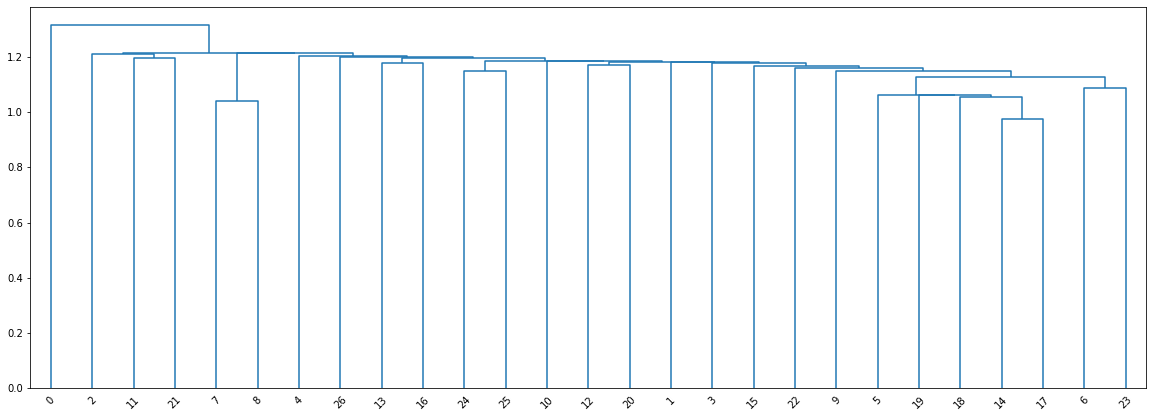

In [126]:
idx = 13
labels = [sent[0] for sent in w2v_presov_for_clust[prefixes[idx]]]
vectors = np.array([sent[-1] for sent in w2v_presov_for_clust[prefixes[idx]]])

cl = hcluster.linkage(vectors)
plt.figure(figsize=(20, 7))
dn = hcluster.dendrogram(cl)
plt.show()

In [127]:
clusters = hcluster.fcluster(cl, 1)
len(set(clusters))

16

In [128]:
clusters_dict = {}

for i, cluster in enumerate(clusters):
    verb = labels[i]
    vector = vectors[i]
    labeled_vector = (verb, vector)
    if cluster not in clusters_dict:
        clusters_dict[cluster] = [labeled_vector]
    else:
        clusters_dict[cluster].append(labeled_vector)

for cluster in clusters_dict:
    elements = [el[0] for el in clusters_dict[cluster]]
    if len(elements) > 2:
        print(cluster)
        print(', '.join(elements))

1
обезглавливать, обезображивать, обессмысливать
6
обезличивать, обезуметь, обеспамятеть, обессилевать, обессиливать


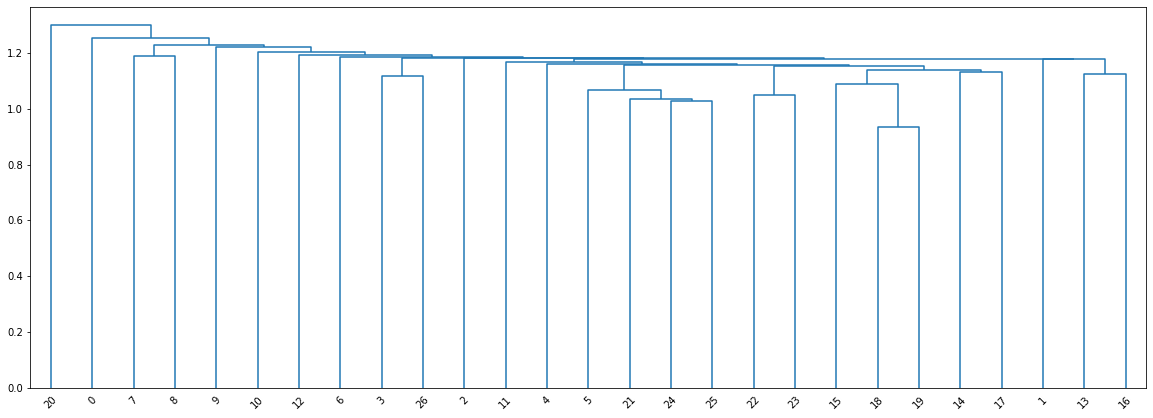

In [129]:
idx = 13
labels = [sent[0] for sent in w2v_sov_for_clust[prefixes[idx]]]
vectors = np.array([sent[-1] for sent in w2v_sov_for_clust[prefixes[idx]]])

cl = hcluster.linkage(vectors)
plt.figure(figsize=(20, 7))
dn = hcluster.dendrogram(cl)
plt.show()

In [130]:
clusters = hcluster.fcluster(cl, 1)
len(set(clusters))

1

In [131]:
clusters_dict = {}

for i, cluster in enumerate(clusters):
    verb = labels[i]
    vector = vectors[i]
    labeled_vector = (verb, vector)
    if cluster not in clusters_dict:
        clusters_dict[cluster] = [labeled_vector]
    else:
        clusters_dict[cluster].append(labeled_vector)

for cluster in clusters_dict:
    elements = [el[0] for el in clusters_dict[cluster]]
    if len(elements) > 2:
        print(cluster)
        print(', '.join(elements))

1
обезволивать, обезвреживать, обезглавливать, обездоливать, обеззараживать, обезличивать, обезличиваться, обезлюдеть, обезлюдить, обезножеть, обезножить, обезображивать, обезопасить, обезоруживать, обезуметь, обескровливать, обескураживать, обеспамятеть, обессилевать, обессиливать, обессмертить, обессмысливать, обесцвечивать, обесцвечиваться, обесценивать, обесцениваться, обесчещивать


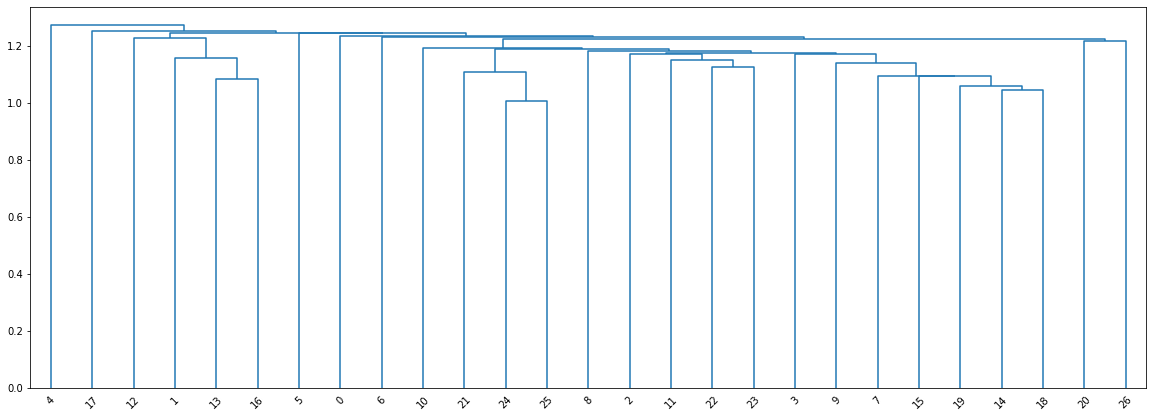

In [132]:
idx = 13
labels = [sent[0] for sent in w2v_postsov_for_clust[prefixes[idx]]]
vectors = np.array([sent[-1] for sent in w2v_postsov_for_clust[prefixes[idx]]])

cl = hcluster.linkage(vectors)
plt.figure(figsize=(20, 7))
dn = hcluster.dendrogram(cl)
plt.show()

In [133]:
clusters = hcluster.fcluster(cl, 1)
len(set(clusters))

12

In [134]:
clusters_dict = {}

for i, cluster in enumerate(clusters):
    verb = labels[i]
    vector = vectors[i]
    labeled_vector = (verb, vector)
    if cluster not in clusters_dict:
        clusters_dict[cluster] = [labeled_vector]
    else:
        clusters_dict[cluster].append(labeled_vector)

for cluster in clusters_dict:
    elements = [el[0] for el in clusters_dict[cluster]]
    if len(elements) > 2:
        print(cluster)
        print(', '.join(elements))

1
обезвреживать, обезопасить, обезоруживать, обескураживать
3
обезглавливать, обезображивать, обесцвечивать, обесцвечиваться
4
обездоливать, обезлюдеть, обезножеть, обезуметь, обескровливать, обессилевать, обессиливать
2
обессмысливать, обесценивать, обесцениваться
